## 1. module import 

In [2]:
import os
import sys
import argparse
import numpy as np
import time
import glob
import cv2

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.config.experimental.set_virtual_device_configuration(
            physical_devices[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)])  # 4GB 제한

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('/home/juju/contact_graspnet/contact_graspnet/inference.py')))
sys.path.append(os.path.join(BASE_DIR))
sys.path.append(os.path.join('/home/juju/contact_graspnet/contact_graspnet'))

import config_utils
from data import regularize_pc_point_count, depth2pc, load_available_input_data

from contact_graspnet import contact_graspnet

from contact_grasp_estimator import GraspEstimator
from visualization_utils import visualize_grasps, show_image

2023-07-07 15:35:54.517643: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-07-07 15:35:55.102913: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-07-07 15:35:55.166631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 15:35:55.166712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 9.77GiB deviceMemoryBandwidth: 707.88GiB/s
2023-07-07 15:35:55.166729: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-07-07 15:35:55.169419: I tensorflow/stream_executor/pl

/home/juju/contact_graspnet/pointnet2/tf_ops/sampling


## 2. argument setting

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--ckpt_dir', default='checkpoints/scene_test_2048_bs3_hor_sigma_001', help='Log dir [default: checkpoints/scene_test_2048_bs3_hor_sigma_001]')
parser.add_argument('--np_path', default='test_data/7.npy', help='Input data: npz/npy file with keys either "depth" & camera matrix "K" or just point cloud "pc" in meters. Optionally, a 2D "segmap"')
parser.add_argument('--png_path', default='', help='Input data: depth map png in meters')
parser.add_argument('--K', default=None, help='Flat Camera Matrix, pass as "[fx, 0, cx, 0, fy, cy, 0, 0 ,1]"')
parser.add_argument('--z_range', default=[0.2,1.8], help='Z value threshold to crop the input point cloud')
parser.add_argument('--local_regions', action='store_true', default=False, help='Crop 3D local regions around given segments.')
parser.add_argument('--filter_grasps', action='store_true', default=False,  help='Filter grasp contacts according to segmap.')
parser.add_argument('--skip_border_objects', action='store_true', default=False,  help='When extracting local_regions, ignore segments at depth map boundary.')
parser.add_argument('--forward_passes', type=int, default=1,  help='Run multiple parallel forward passes to mesh_utils more potential contact points.')
parser.add_argument('--segmap_id', type=int, default=0,  help='Only return grasps of the given object id')
parser.add_argument('--arg_configs', nargs="*", type=str, default=[], help='overwrite config parameters')

FLAGS = parser.parse_args(args=[])

## 3. Config setting

In [4]:
FLAGS.arg_configs

[]

In [5]:
global_config = config_utils.load_config(FLAGS.ckpt_dir, batch_size=FLAGS.forward_passes, arg_configs=FLAGS.arg_configs)

# inference 시 사용할 batch_size이기 때문에 batch를 1로 셋팅한다. 
FLAGS.forward_passes

global_config

/home/juju/contact_graspnet/contact_graspnet/config_utils.py:42: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  global_config = yaml.load(f)


{'DATA': {'scene_contacts_path': 'acronym/scene_contacts',
  'gripper_width': 0.08,
  'input_normals': False,
  'use_uniform_quaternions': False,
  'view_sphere': {'elevation': [30, 150], 'distance_range': [0.9, 1.3]},
  'train_on_scenes': True,
  'labels': {'to_gpu': False,
   'bin_weights': [0.16652107,
    0.21488856,
    0.37031708,
    0.55618503,
    0.75124664,
    0.93943357,
    1.07824539,
    1.19423112,
    1.55731375,
    3.17161779],
   'filter_z': True,
   'k': 1,
   'max_radius': 0.005,
   'num_neg_contacts': 0,
   'num_pos_contacts': 8000,
   'offset_bins': [0,
    0.00794435329,
    0.0158887021,
    0.0238330509,
    0.0317773996,
    0.0397217484,
    0.0476660972,
    0.055610446,
    0.0635547948,
    0.0714991435,
    0.08],
   'z_val': -0.1},
  'pc_augm': {'occlusion_nclusters': 0,
   'occlusion_dropout_rate': 0.0,
   'sigma': 0.0,
   'clip': 0.005},
  'depth_augm': {'sigma': 0.001, 'clip': 0.005, 'gaussian_kernel': 0},
  'raw_num_points': 20000,
  'ndataset_poi

###### config_utils.load_config 코드 분석

In [6]:
import os
import yaml

def recursive_key_value_assign(d,ks,v):
    """
    Recursive value assignment to a nested dict

    Arguments:
        d {dict} -- dict
        ks {list} -- list of hierarchical keys
        v {value} -- value to assign
    """
    
    if len(ks) > 1:
        recursive_key_value_assign(d[ks[0]],ks[1:],v)
    elif len(ks) == 1:
        d[ks[0]] = v
        
def load_config(checkpoint_dir, batch_size=None, max_epoch=None, data_path=None, arg_configs=[], save=False):
    """
    Loads yaml config file and overwrites parameters with function arguments and --arg_config parameters

    Arguments:
        checkpoint_dir {str} -- Checkpoint directory where config file was copied to

    Keyword Arguments:
        batch_size {int} -- [description] (default: {None})
        max_epoch {int} -- "epochs" (number of scenes) to train (default: {None})
        data_path {str} -- path to scenes with contact grasp data (default: {None})
        arg_configs {list} -- Overwrite config parameters by hierarchical command line arguments (default: {[]})
        save {bool} -- Save overwritten config file (default: {False})

    Returns:
        [dict] -- Config
    """

    config_path = os.path.join(checkpoint_dir, 'config.yaml')
#     print(config_path)
#     config_path = config_path if os.path.exists(config_path) else os.path.join(os.path.dirname(__file__),'config.yaml')
    config_path = '/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/config.yaml'
    with open(config_path,'r') as f:
        global_config = yaml.load(f)

    for conf in arg_configs:
        k_str, v = conf.split(':')
        try:
            v = eval(v)
        except:
            pass
        ks = [int(k) if k.isdigit() else k for k in k_str.split('.')]
        
        recursive_key_value_assign(global_config, ks, v)
        
    if batch_size is not None:
        global_config['OPTIMIZER']['batch_size'] = int(batch_size)
    if max_epoch is not None:
        global_config['OPTIMIZER']['max_epoch'] = int(max_epoch)
    if data_path is not None:
        global_config['DATA']['data_path'] = data_path
    
#     print(data_path)
    global_config['DATA']['classes'] = None
    
    if save:
        with open(os.path.join(checkpoint_dir, 'config.yaml'),'w') as f:
            yaml.dump(global_config, f)

    return global_config

In [7]:
global_config = load_config(FLAGS.ckpt_dir, batch_size=FLAGS.forward_passes, arg_configs=FLAGS.arg_configs)

/tmp/ipykernel_65970/3358985416.py:42: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  global_config = yaml.load(f)


In [8]:
checkpoint_dir = '/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/'
# config_path = os.path.join(checkpoint_dir, 'config.yaml')

# os.path.exists(checkpoint_dir)

# with open(config_path,'r') as f:
#     global_config = yaml.load(f)

global_config

{'DATA': {'gripper_width': 0.08,
  'input_normals': False,
  'use_uniform_quaternions': False,
  'train_on_scenes': True,
  'labels': {'to_gpu': False,
   'bin_weights': [0.16652107,
    0.21488856,
    0.37031708,
    0.55618503,
    0.75124664,
    0.93943357,
    1.07824539,
    1.19423112,
    1.55731375,
    3.17161779],
   'contact_gather': 'knn',
   'filter_z': True,
   'k': 1,
   'max_radius': 0.005,
   'min_unique_pos_contacts': 1,
   'num_neg_contacts': 0,
   'num_pos_contacts': 10000,
   'offset_bins': [0,
    0.00794435329,
    0.0158887021,
    0.0238330509,
    0.0317773996,
    0.0397217484,
    0.0476660972,
    0.055610446,
    0.0635547948,
    0.0714991435,
    0.08],
   'z_val': -0.1},
  'raw_num_points': 20000,
  'ndataset_points': 20000,
  'num_point': 2048,
  'sigma': 0.001,
  'clip': 0.005,
  'use_farthest_point': False,
  'train_and_test': False,
  'num_test_scenes': 1000,
  'intrinsics': 'realsense',
  'classes': None},
 'LOSS': {'min_geom_loss_divisor': 1.0,


In [9]:
def inference(global_config, checkpoint_dir, input_paths, K=None, local_regions=True, skip_border_objects=False, filter_grasps=True, segmap_id=None, z_range=[0.2,1.8], forward_passes=1):
    """
    Predict 6-DoF grasp distribution for given model and input data
    
    :param global_config: config.yaml from checkpoint directory
    :param checkpoint_dir: checkpoint directory
    :param input_paths: .png/.npz/.npy file paths that contain depth/pointcloud and optionally intrinsics/segmentation/rgb
    :param K: Camera Matrix with intrinsics to convert depth to point cloud
    :param local_regions: Crop 3D local regions around given segments. 
    :param skip_border_objects: When extracting local_regions, ignore segments at depth map boundary.
    :param filter_grasps: Filter and assign grasp contacts according to segmap.
    :param segmap_id: only return grasps from specified segmap_id.
    :param z_range: crop point cloud at a minimum/maximum z distance from camera to filter out outlier points. Default: [0.2, 1.8] m
    :param forward_passes: Number of forward passes to run on each point cloud. Default: 1
    """
    
    # Build the model
    grasp_estimator = GraspEstimator(global_config)
    grasp_estimator.build_network()

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver(save_relative_paths=True)

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)

    # Load weights
    grasp_estimator.load_weights(sess, saver, checkpoint_dir, mode='test')
    
    os.makedirs('results', exist_ok=True)

    # Process example test scenes
    for p in glob.glob(input_paths):
        print('Loading ', p)

        pc_segments = {}
        segmap, rgb, depth, cam_K, pc_full, pc_colors = load_available_input_data(p, K=K)
        
        if segmap is None and (local_regions or filter_grasps):
            raise ValueError('Need segmentation map to extract local regions or filter grasps')

        if pc_full is None:
            print('Converting depth to point cloud(s)...')
            pc_full, pc_segments, pc_colors = grasp_estimator.extract_point_clouds(depth, cam_K, segmap=segmap, rgb=rgb,
                                                                                    skip_border_objects=skip_border_objects, z_range=z_range)

        print('Generating Grasps...')
        pred_grasps_cam, scores, contact_pts, _ = grasp_estimator.predict_scene_grasps(sess, pc_full, pc_segments=pc_segments, 
                                                                                          local_regions=local_regions, filter_grasps=filter_grasps, forward_passes=forward_passes)  

        # Save results
        np.savez('results/predictions_{}'.format(os.path.basename(p.replace('png','npz').replace('npy','npz'))), 
                  pred_grasps_cam=pred_grasps_cam, scores=scores, contact_pts=contact_pts)

        # Visualize results          
        show_image(rgb, segmap)
        visualize_grasps(pc_full, pred_grasps_cam, scores, plot_opencv_cam=True, pc_colors=pc_colors)
        
        break


## inference 분석

In [11]:
## Config를 받아서 GraspEstimatorr Class를 받아옴. 
grasp_estimator = GraspEstimator(global_config)


<module 'contact_graspnet.contact_graspnet' from '/home/juju/contact_graspnet/contact_graspnet/contact_graspnet.py'>


In [12]:
grasp_estimator.placeholders,

grasp_estimator.model_ops

{}

In [13]:
grasp_estimator.placeholders

{'pointclouds_pl': <tf.Tensor 'Placeholder:0' shape=(1, 20000, 3) dtype=float32>,
 'scene_idx_pl': <tf.Tensor 'Placeholder_1:0' shape=() dtype=int32>,
 'cam_poses_pl': <tf.Tensor 'Placeholder_2:0' shape=(1, 4, 4) dtype=float32>,
 'is_training_pl': <tf.Tensor 'Placeholder_3:0' shape=() dtype=bool>}

### build config 
> get config param.


can choose whether use point cloud's normal or not 

## Build network 

1. optimizer의 step에 따른 batch_norm decay를 받아오고


2. Model을 받아옴 
> pc, train_eval_mode, config, bn_decay를 입력 받아 모델을 구성. 
    

In [15]:
from tf_train_ops import get_bn_decay
step = tf.Variable(0)

bn_decay = get_bn_decay(step, global_config['OPTIMIZER'])
bn_decay

<tf.Tensor 'Minimum:0' shape=() dtype=float32>

In [16]:
from tf_sampling import farthest_point_sample, gather_point
from pointnet_util import pointnet_sa_module, pointnet_fp_module, pointnet_sa_module_msg


model_config = global_config['MODEL']
data_config = global_config['DATA']

radius_list_0 = model_config['pointnet_sa_modules_msg'][0]['radius_list']
radius_list_1 = model_config['pointnet_sa_modules_msg'][1]['radius_list']
radius_list_2 = model_config['pointnet_sa_modules_msg'][2]['radius_list']

nsample_list_0 = model_config['pointnet_sa_modules_msg'][0]['nsample_list']
nsample_list_1 = model_config['pointnet_sa_modules_msg'][1]['nsample_list']
nsample_list_2 = model_config['pointnet_sa_modules_msg'][2]['nsample_list']

mlp_list_0 = model_config['pointnet_sa_modules_msg'][0]['mlp_list']
mlp_list_1 = model_config['pointnet_sa_modules_msg'][1]['mlp_list']
mlp_list_2 = model_config['pointnet_sa_modules_msg'][2]['mlp_list']

npoint_0 = model_config['pointnet_sa_modules_msg'][0]['npoint']
npoint_1 = model_config['pointnet_sa_modules_msg'][1]['npoint']
npoint_2 = model_config['pointnet_sa_modules_msg'][2]['npoint']

fp_mlp_0 = model_config['pointnet_fp_modules'][0]['mlp']
fp_mlp_1 = model_config['pointnet_fp_modules'][1]['mlp']
fp_mlp_2 = model_config['pointnet_fp_modules'][2]['mlp']

input_normals = data_config['input_normals']
offset_bins = data_config['labels']['offset_bins']
joint_heads = model_config['joint_heads']

# expensive, rather use random only
if 'raw_num_points' in data_config and data_config['raw_num_points'] != data_config['ndataset_points']:
    point_cloud = gather_point(point_cloud, farthest_point_sample(data_config['ndataset_points'], point_cloud))

point_cloud = grasp_estimator.placeholders['pointclouds_pl']

end_points = {}
l0_xyz = tf.slice(point_cloud, [0,0,0], [-1,-1,3])
l0_points = tf.slice(point_cloud, [0,0,3], [-1,-1,3]) if input_normals else None 


In [17]:
model_config['pointnet_sa_modules_msg']

[{'mlp_list': [[32, 32, 64], [64, 64, 128], [64, 96, 128]],
  'npoint': 2048,
  'nsample_list': [32, 64, 128],
  'radius_list': [0.02, 0.04, 0.08]},
 {'mlp_list': [[64, 64, 128], [128, 128, 256], [128, 128, 256]],
  'npoint': 512,
  'nsample_list': [64, 64, 128],
  'radius_list': [0.04, 0.08, 0.16]},
 {'mlp_list': [[64, 64, 128], [128, 128, 256], [128, 128, 256]],
  'npoint': 128,
  'nsample_list': [64, 64, 128],
  'radius_list': [0.08, 0.16, 0.32]}]

In [18]:
l0_xyz, l0_points, npoint_0


(<tf.Tensor 'Slice:0' shape=(1, 20000, 3) dtype=float32>, None, 2048)

In [19]:
# Set abstraction layers
is_training = False
l1_xyz, l1_points = pointnet_sa_module_msg(l0_xyz, l0_points, npoint_0, radius_list_0, nsample_list_0, mlp_list_0, is_training, bn_decay, scope='layer1')
l2_xyz, l2_points = pointnet_sa_module_msg(l1_xyz, l1_points, npoint_1, radius_list_1, nsample_list_1,mlp_list_1, is_training, bn_decay, scope='layer2')


/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [20]:
l1_xyz, l1_points, npoint_1

(<tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 <tf.Tensor 'layer1/concat:0' shape=(1, 2048, 320) dtype=float32>,
 512)

In [21]:
l2_xyz, l2_points, npoint_2

(<tf.Tensor 'layer2/GatherPoint:0' shape=(1, 512, 3) dtype=float32>,
 <tf.Tensor 'layer2/concat_3:0' shape=(1, 512, 640) dtype=float32>,
 128)

In [22]:
if 'asymmetric_model' in model_config and model_config['asymmetric_model']:
    l3_xyz, l3_points = pointnet_sa_module_msg(l2_xyz, l2_points, npoint_2, radius_list_2, nsample_list_2,mlp_list_2, is_training, bn_decay, scope='layer3')
    l4_xyz, l4_points, _ = pointnet_sa_module(l3_xyz, l3_points, npoint=None, radius=None, nsample=None, mlp=model_config['pointnet_sa_module']['mlp'], mlp2=None, group_all=model_config['pointnet_sa_module']['group_all'], is_training=is_training, bn_decay=bn_decay, scope='layer4')

    # Feature Propagation layers
    l3_points = pointnet_fp_module(l3_xyz, l4_xyz, l3_points, l4_points, fp_mlp_0, is_training, bn_decay, scope='fa_layer1')
    l2_points = pointnet_fp_module(l2_xyz, l3_xyz, l2_points, l3_points, fp_mlp_1, is_training, bn_decay, scope='fa_layer2')
    l1_points = pointnet_fp_module(l1_xyz, l2_xyz, l1_points, l2_points, fp_mlp_2, is_training, bn_decay, scope='fa_layer3')

    l0_points = l1_points
    pred_points = l1_xyz
else:
    l3_xyz, l3_points, _ = pointnet_sa_module(l2_xyz, l2_points, npoint=None, radius=None, nsample=None, mlp=model_config['pointnet_sa_module']['mlp'], mlp2=None, group_all=model_config['pointnet_sa_module']['group_all'], is_training=is_training, bn_decay=bn_decay, scope='layer3')
  
    # Feature Propagation layers
    l2_points = pointnet_fp_module(l2_xyz, l3_xyz, l2_points, l3_points, fp_mlp_0, is_training, bn_decay, scope='fa_layer1')
    l1_points = pointnet_fp_module(l1_xyz, l2_xyz, l1_points, l2_points, fp_mlp_1, is_training, bn_decay, scope='fa_layer2')
    l0_points = tf.concat([l0_xyz, l0_points],axis=-1) if input_normals else l0_xyz 
    l0_points = pointnet_fp_module(l0_xyz, l1_xyz, l0_points, l1_points, fp_mlp_2, is_training, bn_decay, scope='fa_layer3')
    pred_points = l0_xyz


In [23]:
l3_xyz, l3_points

(<tf.Tensor 'layer3/GatherPoint:0' shape=(1, 128, 3) dtype=float32>,
 <tf.Tensor 'fa_layer1/Squeeze:0' shape=(1, 128, 256) dtype=float32>)

In [24]:
l1_xyz, l1_points, npoint_1

(<tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 <tf.Tensor 'fa_layer3/Squeeze:0' shape=(1, 2048, 128) dtype=float32>,
 512)

# Build Net

In [14]:
grasp_estimator.build_network()

--- Get model
Instructions for updating:
Colocations handled automatically by placer.


/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/juju/anaconda3/envs/contact_graspnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


{'pointclouds_pl': <tf.Tensor 'Placeholder:0' shape=(1, 20000, 3) dtype=float32>,
 'cam_poses_pl': <tf.Tensor 'Placeholder_2:0' shape=(1, 4, 4) dtype=float32>,
 'scene_idx_pl': <tf.Tensor 'Placeholder_1:0' shape=() dtype=int32>,
 'is_training_pl': <tf.Tensor 'Placeholder_3:0' shape=() dtype=bool>,
 'grasp_dir_pred': <tf.Tensor 'l2_normalize:0' shape=(1, 2048, 3) dtype=float32>,
 'binary_seg_head': <tf.Tensor 'fc2_seg/BiasAdd:0' shape=(1, 2048, 1) dtype=float32>,
 'binary_seg_pred': <tf.Tensor 'Sigmoid:0' shape=(1, 2048, 1) dtype=float32>,
 'grasp_offset_head': <tf.Tensor 'fc2_off/BiasAdd:0' shape=(1, 2048, 10) dtype=float32>,
 'grasp_offset_pred': <tf.Tensor 'Sigmoid_1:0' shape=(1, 2048, 10) dtype=float32>,
 'approach_dir_pred': <tf.Tensor 'l2_normalize_1:0' shape=(1, 2048, 3) dtype=float32>,
 'pred_points': <tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 'offset_pred_idcs_pc': <tf.Tensor 'ArgMax_1:0' shape=(1, 2048) dtype=int64>,
 'offset_bin_pred_vals': <tf.Tens

In [15]:
grasp_estimator._num_input_points

20000

# Make Session

In [16]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver(save_relative_paths=True)

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

2023-07-07 15:36:23.252660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 15:36:23.253344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 15:36:23.253459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 9.77GiB deviceMemoryBandwidth: 707.88GiB/s
2023-07-07 15:36:23.253511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), 

## Load weights & data

In [17]:
tf.train.get_checkpoint_state(checkpoint_dir)

model_checkpoint_path: "/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054"
all_model_checkpoint_paths: "/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-108108"
all_model_checkpoint_paths: "/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-117117"
all_model_checkpoint_paths: "/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-126126"
all_model_checkpoint_paths: "/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-135135"
all_model_checkpoint_paths: "/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-144144"

In [19]:

# Load weights
grasp_estimator.load_weights(sess, saver, checkpoint_dir, mode='test')
saver.restore(sess, '/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-144144')

('loading ', '/home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')
INFO:tensorflow:Restoring parameters from /home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054
INFO:tensorflow:Restoring parameters from /home/juju/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-144144


In [20]:
os.makedirs('results', exist_ok=True)

p = "/home/juju/contact_graspnet/test_data/0.npy"
K=FLAGS.K

print('Loading ', p)

pc_segments = {}
segmap, rgb, depth, cam_K, pc_full, pc_colors = load_available_input_data(p, K=K)


Loading  /home/juju/contact_graspnet/test_data/0.npy


In [22]:

z_range=eval(str(FLAGS.z_range))


if pc_full is None:
    print('Converting depth to point cloud(s)...')
    pc_full, pc_segments, pc_colors = grasp_estimator.extract_point_clouds(depth, cam_K, segmap=segmap, rgb=rgb,
                                                                                    skip_border_objects=FLAGS.skip_border_objects, z_range=z_range)


In [25]:
np.unique(segmap[segmap>0]), pc_colors, pc_full

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       dtype=float32),
 array([[125, 138, 133],
        [124, 137, 132],
        [124, 136, 128],
        ...,
        [  0, 135,   0],
        [  0, 135,   0],
        [  0, 135,   0]], dtype=uint8),
 array([[-0.0253798 , -0.40076566,  1.007     ],
        [-0.0242765 , -0.40076566,  1.007     ],
        [-0.02303514, -0.3983778 ,  1.001     ],
        ...,
        [ 0.5249808 ,  0.2973849 ,  0.763     ],
        [ 0.52581674,  0.2973849 ,  0.763     ],
        [ 0.5266527 ,  0.2973849 ,  0.763     ]], dtype=float32))

In [28]:
pc_segments

{1.0: array([[ 0.01981384,  0.14888741,  0.952     ],
        [ 0.02081306,  0.14857464,  0.95      ],
        [ 0.0218539 ,  0.14857464,  0.95      ],
        ...,
        [-0.01688482,  0.24641371,  0.856     ],
        [-0.01782267,  0.24735154,  0.856     ],
        [-0.01688482,  0.24735154,  0.856     ]], dtype=float32),
 2.0: array([[-0.05934548, -0.33888054,  1.062     ],
        [-0.05818192, -0.33888054,  1.062     ],
        [-0.05934548, -0.337717  ,  1.062     ],
        ...,
        [-0.0109788 ,  0.03257431,  1.252     ],
        [-0.00960708,  0.03257431,  1.252     ],
        [-0.00823535,  0.03257431,  1.252     ]], dtype=float32),
 3.0: array([[0.06334933, 0.01513088, 1.285     ],
        [0.064858  , 0.01515443, 1.287     ],
        [0.06626806, 0.01515443, 1.287     ],
        ...,
        [0.18596345, 0.24075326, 0.866     ],
        [0.18691227, 0.24075326, 0.866     ],
        [0.18764414, 0.24047525, 0.865     ]], dtype=float32),
 4.0: array([[0.69895184, 0.113

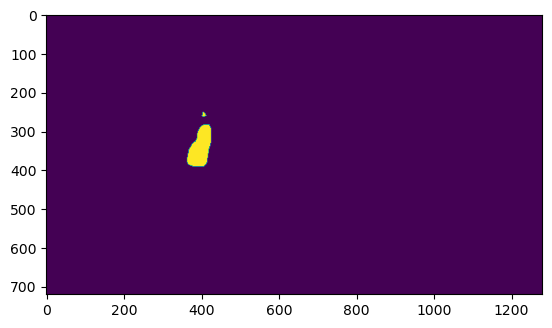

In [46]:
import matplotlib.pyplot as plt

plt.imshow(segmap==5)

In [30]:
pc_full, pc_segments, pc_colors

(array([[-0.0253798 , -0.40076566,  1.007     ],
        [-0.0242765 , -0.40076566,  1.007     ],
        [-0.02303514, -0.3983778 ,  1.001     ],
        ...,
        [ 0.5249808 ,  0.2973849 ,  0.763     ],
        [ 0.52581674,  0.2973849 ,  0.763     ],
        [ 0.5266527 ,  0.2973849 ,  0.763     ]], dtype=float32),
 {1.0: array([[ 0.01981384,  0.14888741,  0.952     ],
         [ 0.02081306,  0.14857464,  0.95      ],
         [ 0.0218539 ,  0.14857464,  0.95      ],
         ...,
         [-0.01688482,  0.24641371,  0.856     ],
         [-0.01782267,  0.24735154,  0.856     ],
         [-0.01688482,  0.24735154,  0.856     ]], dtype=float32),
  2.0: array([[-0.05934548, -0.33888054,  1.062     ],
         [-0.05818192, -0.33888054,  1.062     ],
         [-0.05934548, -0.337717  ,  1.062     ],
         ...,
         [-0.0109788 ,  0.03257431,  1.252     ],
         [-0.00960708,  0.03257431,  1.252     ],
         [-0.00823535,  0.03257431,  1.252     ]], dtype=float32),
  3.

In [38]:
pc_full
from data import farthest_points, distance_by_translation_point, preprocess_pc_for_inference, regularize_pc_point_count, depth2pc, reject_median_outliers

pc_full2 = regularize_pc_point_count(pc_full, global_config['DATA']['raw_num_points'])

pred_grasps_cam, scores, contact_pts, gripper_openings = {}, {}, {}, {}



Random sample points 


In [42]:
pc_full2.shape, pc_full.shape

((20000, 3), (493949, 3))

In [39]:
pc_regions, _ = grasp_estimator.extract_3d_cam_boxes(pc_full, pc_segments)

Extracted Region Cube Size:  0.33600008487701416
Random sample points 
Extracted Region Cube Size:  0.6
Random sample points 
Extracted Region Cube Size:  0.3739999532699585
Random sample points 
Extracted Region Cube Size:  0.6
Random sample points 
Extracted Region Cube Size:  0.6
Random sample points 
Extracted Region Cube Size:  0.34800004959106445
Random sample points 
Extracted Region Cube Size:  0.5500000715255737
Random sample points 
Extracted Region Cube Size:  0.3760000467300415
Random sample points 
Extracted Region Cube Size:  0.4620000123977661
Random sample points 
Extracted Region Cube Size:  0.6
Random sample points 
Extracted Region Cube Size:  0.6
Random sample points 


In [25]:
grasp_estimator.inference_ops, pc_regions

([<tf.Tensor 'concat_2:0' shape=(1, 2048, 4, 4) dtype=float32>,
  <tf.Tensor 'Sigmoid:0' shape=(1, 2048, 1) dtype=float32>,
  <tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
  <tf.Tensor 'GatherNd:0' shape=(1, 2048) dtype=float32>],
 {1.0: array([[0.09638831, 0.20544712, 0.907     ],
         [0.08649368, 0.1727371 , 0.918     ],
         [0.13177063, 0.25022283, 0.853     ],
         ...,
         [0.01287215, 0.22160478, 0.904     ],
         [0.03330377, 0.25834057, 0.8       ],
         [0.0695549 , 0.14556319, 1.024     ]], dtype=float32),
  2.0: array([[-0.057902  , -0.13454552,  1.201     ],
         [ 0.14425692,  0.16242293,  0.99      ],
         [-0.09805809,  0.14122543,  1.017     ],
         ...,
         [ 0.01925474, -0.34014148,  1.034     ],
         [ 0.24568413,  0.13569422,  1.043     ],
         [-0.02339415,  0.08153306,  1.186     ]], dtype=float32),
  3.0: array([[0.07247134, 0.12970263, 1.05      ],
         [0.37982786, 0.27576882, 0.81  

# visualize region

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
from trimesh.util import concatenate

colors = np.random.randint(0, 255, (1, 3), dtype=np.uint8)  # RGB colors (0-255)
pc_region_1 = pc_regions[5.0]

pc_region_test = trimesh.points.PointCloud(pc_region_1,  colors=colors)
scene = trimesh.Scene(pc_region_test)

scene.point_size=5.0
scene.show()

In [33]:
pc_region_1.shape, pc_segments[1.0].shape

((20000, 3), (13481, 3))

In [22]:
grasp_estimator.model_ops['pred_points'], grasp_estimator.model_ops['grasp_offset_head']

(<tf.Tensor 'layer1/GatherPoint:0' shape=(1, 2048, 3) dtype=float32>,
 <tf.Tensor 'fc2_off/BiasAdd:0' shape=(1, 2048, 10) dtype=float32>)

In [23]:
grasp_estimator.model_ops['offset_bin_pred_vals']

<tf.Tensor 'GatherNd:0' shape=(1, 2048) dtype=float32>

In [24]:
np.minimum(0.075 + grasp_estimator._contact_grasp_cfg['TEST']['extra_opening'], grasp_estimator._contact_grasp_cfg['DATA']['gripper_width']), grasp_estimator._contact_grasp_cfg['DATA']['gripper_width'] 

(0.08, 0.08)

# Grasp Predict 

In [1]:
offset_pred = np.array([[grasp_estimator._contact_grasp_cfg['DATA']['gripper_width']-grasp_estimator._contact_grasp_cfg['TEST']['extra_opening']]*grasp_estimator._contact_grasp_cfg['DATA']['num_point']])

gripper_openings = np.minimum(offset_pred+ grasp_estimator._contact_grasp_cfg['TEST']['extra_opening'], grasp_estimator._contact_grasp_cfg['DATA']['gripper_width'])

gripper_openings

NameError: name 'np' is not defined

# Predict Scene Grasps

In [30]:
pred_grasps_cam, scores, contact_pts, gripper_openings = grasp_estimator.predict_scene_grasps(sess, pc_full2, pc_segments=pc_segments,\
                                                                                              filter_grasps=True,\
                                                                                              local_regions=True,\
                                                                                              forward_passes=FLAGS.forward_passes\
                                                                                             )


Extracted Region Cube Size:  0.33600008487701416
Extracted Region Cube Size:  0.6
Extracted Region Cube Size:  0.3739999532699585
Extracted Region Cube Size:  0.6
Extracted Region Cube Size:  0.6
Extracted Region Cube Size:  0.34800004959106445
Extracted Region Cube Size:  0.5500000715255737
Extracted Region Cube Size:  0.3760000467300415
Extracted Region Cube Size:  0.4620000123977661
Extracted Region Cube Size:  0.6
Extracted Region Cube Size:  0.6
Generated 2 grasps for object 1.0
Generated 12 grasps for object 2.0
Generated 42 grasps for object 3.0
Generated 110 grasps for object 4.0
Generated 35 grasps for object 5.0
Generated 109 grasps for object 6.0
Generated 73 grasps for object 7.0
Generated 53 grasps for object 8.0
Generated 49 grasps for object 9.0
Generated 5 grasps for object 10.0


In [36]:
pc_full2.shape, pc_colors.shape

((20000, 3), (493949, 3))

In [38]:
visualize_grasps(pc_full2, pred_grasps_cam, scores, plot_opencv_cam=False)

Visualizing...takes time


In [27]:
pred_grasps_cam

{1.0: array([[[-0.3501471 ,  0.9279283 ,  0.12785119, -0.0122563 ],
         [-0.4391116 , -0.28317335,  0.8526393 ,  0.07181394],
         [ 0.8273922 ,  0.24240823,  0.5066165 ,  0.8815457 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
 
        [[-0.14159927,  0.98167735,  0.12751201,  0.00848072],
         [-0.37862292, -0.1727231 ,  0.90929174,  0.06309842],
         [ 0.9146553 ,  0.08047608,  0.396143  ,  0.8984886 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]],
       dtype=float32),
 2.0: array([[[ 0.5468645 ,  0.7782818 ,  0.3085721 , -0.18292248],
         [-0.6548342 ,  0.16796981,  0.7368706 , -0.17926514],
         [ 0.52166224, -0.60503197,  0.60150224,  1.2998407 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
 
        [[ 0.6108289 ,  0.51947546,  0.59752256, -0.19689411],
         [-0.63765496, -0.12459829,  0.76017845, -0.18938233],
         [ 0.4693444 , -0.8453522 ,  0.2551379 ,  1.3094151 ],
         [ 0. 

In [28]:
for i in range (1,10):
    print(np.max(gripper_openings[i]))

0.016916528
0.016916528
0.032805227
0.04869392
0.05663827
0.016916528
0.032805227
0.07252697
0.016916528


In [40]:
pc_full

array([[-0.0253798 , -0.40076566,  1.007     ],
       [-0.0242765 , -0.40076566,  1.007     ],
       [-0.02303514, -0.3983778 ,  1.001     ],
       ...,
       [ 0.5249808 ,  0.2973849 ,  0.763     ],
       [ 0.52581674,  0.2973849 ,  0.763     ],
       [ 0.5266527 ,  0.2973849 ,  0.763     ]], dtype=float32)

In [41]:

local_regions = FLAGS.local_regions
filter_grasps=FLAGS.filter_grasps
forward_passes = FLAGS.forward_passes
print('Generating Grasps...')
pred_grasps_cam, scores, contact_pts, _ = grasp_estimator.predict_scene_grasps(sess, pc_full, pc_segments=pc_segments, 
                                                                  local_regions=local_regions, filter_grasps=filter_grasps, forward_passes=forward_passes)  

Generating Grasps...
Random sample points 
Generated 148 grasps


In [43]:
for i, grasps in pred_grasps_cam.items():
    print(i, grasps.shape)

-1 (148, 4, 4)


In [44]:
pc_full

array([[-0.0253798 , -0.40076566,  1.007     ],
       [-0.0242765 , -0.40076566,  1.007     ],
       [-0.02303514, -0.3983778 ,  1.001     ],
       ...,
       [ 0.5249808 ,  0.2973849 ,  0.763     ],
       [ 0.52581674,  0.2973849 ,  0.763     ],
       [ 0.5266527 ,  0.2973849 ,  0.763     ]], dtype=float32)

In [199]:
contact_pts

{-1: array([[ 2.11400092e-01,  2.75167048e-01,  7.12000012e-01],
        [ 4.48552310e-01,  2.79934227e-01,  7.39000022e-01],
        [ 7.41537660e-02, -3.32750112e-01,  1.16700006e+00],
        [-1.23679422e-01, -1.12399109e-01,  1.32799995e+00],
        [ 4.85212952e-02,  2.37799704e-01,  7.03000009e-01],
        [ 5.46904430e-02,  2.02317059e-01,  7.79999971e-01],
        [ 3.64833355e-01,  2.26033047e-01,  7.62000024e-01],
        [-8.15506503e-02,  1.91856414e-01,  8.27000022e-01],
        [-3.82931918e-01, -1.07360415e-01,  1.41499996e+00],
        [-6.69571161e-02,  1.54705003e-01,  8.73000026e-01],
        [-1.48067653e-01,  2.66621977e-01,  6.85999990e-01],
        [ 9.22291160e-01, -4.66055959e-01,  1.38000000e+00],
        [ 3.95402163e-01,  2.09469333e-01,  8.10999990e-01],
        [ 3.63498479e-01,  1.92867279e-01,  8.64000022e-01],
        [-1.58991277e-01,  2.18602180e-01,  7.48000026e-01],
        [-1.87313437e-01,  1.97834313e-01,  8.18000019e-01],
        [-3.68178666

array([[912.72143555,   0.        , 649.00366211],
       [  0.        , 912.7409668 , 363.25247192],
       [  0.        ,   0.        ,   1.        ]])

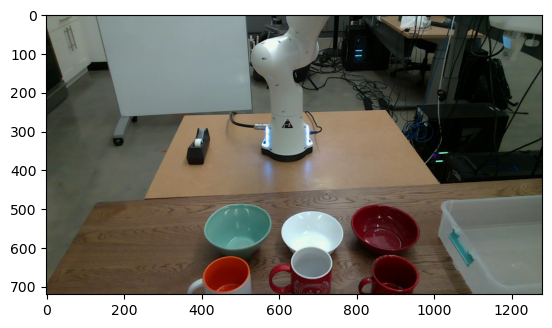

In [45]:
import matplotlib.pyplot as plt

plt.imshow(segmap)
plt.imshow(rgb)
cam_K

<Figure size 640x480 with 0 Axes>

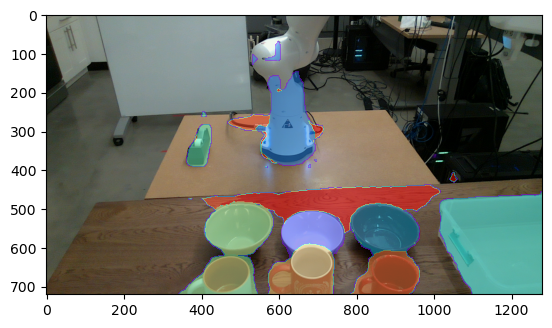

In [46]:
# Visualize results          
show_image(rgb, segmap)

In [47]:
visualize_grasps(pc_full, pred_grasps_cam, scores, plot_opencv_cam=False, pc_colors=pc_colors)


Visualizing...takes time


In [208]:
k=1.0
gripper_openings_k = np.ones(len(pred_grasps_cam[k]))*gripper_width if gripper_openings is None else gripper_openings[k]

In [209]:
gripper_openings_k

array([0.01691653, 0.01691653, 0.01691653, 0.01691653], dtype=float32)

In [213]:
 0.1034/2

0.0517

In [211]:
import mesh_utils

gripper = mesh_utils.create_gripper('panda')
gripper_control_points = gripper.get_control_point_tensor(1, False, convex_hull=False).squeeze()
mid_point = 0.5*(gripper_control_points[1, :] + gripper_control_points[2, :])
grasp_line_plot = np.array([np.zeros((3,)), mid_point, gripper_control_points[1], gripper_control_points[3], 
                            gripper_control_points[1], gripper_control_points[2], gripper_control_points[4]])

In [212]:
grasp_line_plot

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.84000014e-02],
       [ 5.26874326e-02, -5.99553132e-05,  5.84000014e-02],
       [ 5.26874326e-02, -5.99553132e-05,  1.05273142e-01],
       [ 5.26874326e-02, -5.99553132e-05,  5.84000014e-02],
       [-5.26874326e-02,  5.99553132e-05,  5.84000014e-02],
       [-5.26874326e-02,  5.99553132e-05,  1.05273142e-01]])

In [ ]:
inference()

## Acronym mesh_contacts 파일 뜯어보기

In [29]:
bowl = np.load('/home/juju/contact_graspnet/acronym/mesh_contacts/Bowl_fa23aa60ec51c8e4c40fe5637f0a27e1_0.0006927004766994205.npz')

In [30]:
for i in bowl:
    print(i)

collisions
valid_locations
successful
grasp_transform
contact_points
contact_directions
contact_face_normals
contact_offsets


In [60]:
# successful : grasp 성공인지아닌지
np.where(bowl['successful'])
# grasp을 위한 eef_pose
bowl['grasp_transform']
# gripper 손가락의 direction (내생각)  shape : 2x3
bowl['contact_directions'] 
# gripper가 닿을 object의 face normal (확실치 않음)
bowl['contact_face_normals'][0]
# 모르겠네.. 코드 봐야할듯. 
bowl['contact_offsets']

print()